This notebook is used to produce figure 4, showing the approximate equivalence of temporal/atemporal results from a phasor neuron with many inputs (784).

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as be

In [2]:
from utils import *
from data import *
from layers import *
from models import *

In [3]:
from scipy.stats import pearsonr

In [4]:
limit_gpus()
set_gpu(0)

In [5]:
dpi=100

# Train example model

Train a full MLP model to demonstrate the layer working with weights that are realistic for a use-case. 

In [6]:
dataset = "fashion_mnist"
ds_train, ds_test, ds_info = load_dataset(dataset, 128)

input_shape = ds_info.features['image'].shape
num_classes = ds_info.features['label'].num_classes

In [7]:
xs, ys = next(iter(ds_train))

In [8]:
model = PhasorModel(input_shape, onehot_offset=0.0, onehot_phase=0.5, max_step=0.05, projection="dot")

In [9]:
model.compile(optimizer="rmsprop")
loss = model.train(ds_train, 2)

Training loss tf.Tensor(0.8981473, shape=(), dtype=float32)
Training loss tf.Tensor(0.041440472, shape=(), dtype=float32)
Training loss tf.Tensor(0.03752713, shape=(), dtype=float32)
Training loss tf.Tensor(0.03199639, shape=(), dtype=float32)
Training loss tf.Tensor(0.033444528, shape=(), dtype=float32)
Training loss tf.Tensor(0.029397147, shape=(), dtype=float32)
Training loss tf.Tensor(0.022563573, shape=(), dtype=float32)
Training loss tf.Tensor(0.022413466, shape=(), dtype=float32)
Training loss tf.Tensor(0.023469739, shape=(), dtype=float32)
Training loss tf.Tensor(0.032699626, shape=(), dtype=float32)


In [10]:
model.accuracy(ds_test, method="static", confusion=False)

(<tf.Tensor: shape=(), dtype=float64, numpy=0.8372>,)

# Make equivalent layer

Slice out the first layer and probe its functionality more carefully.

In [11]:
wt = model.dense1.w

In [12]:
wt.shape

TensorShape([784, 100])

In [13]:
n_in, n_out = wt.shape

Create a series of random samples and a smaller model to execute only the first layer.

In [14]:
n_samples = 64

In [16]:
model2 = keras.Sequential([keras.Input((n_in)), CmpxLinear((n_out), max_step=0.05)])

In [17]:
model2.layers[0].weights[0].assign(wt)

<tf.Variable 'UnreadVariable' shape=(784, 100) dtype=float32, numpy=
array([[ 0.05611207,  0.01105799, -0.06072964, ...,  0.09021807,
         0.06924436, -0.03352933],
       [ 0.07389169, -0.11493546,  0.01236808, ..., -0.00083805,
         0.0564283 , -0.02868243],
       [ 0.07148491, -0.10562242,  0.02327335, ..., -0.00449878,
         0.07015203,  0.07215302],
       ...,
       [ 0.01626224, -0.06927229,  0.05995116, ..., -0.00246056,
        -0.04245818, -0.04827622],
       [-0.00906406, -0.00727009,  0.05028093, ...,  0.03311469,
         0.02301479,  0.06753485],
       [-0.01981557, -0.02045443,  0.02348496, ..., -0.00281965,
         0.04522503, -0.03309529]], dtype=float32)>

In [18]:
random_inputs = tf.random.uniform((64, n_in), minval=-1.0, maxval=1.0)

In [19]:
static_phases = model2(random_inputs)

Text(0.5, 1.0, 'Atemporal output phase from random inputs')

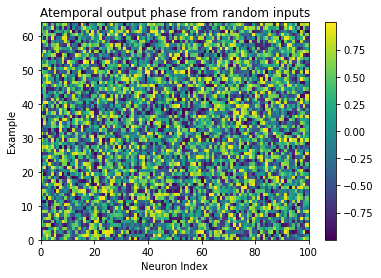

In [20]:
plt.pcolor(static_phases)
plt.colorbar()
plt.xlabel("Neuron Index")
plt.ylabel("Example")
plt.title("Atemporal output phase from random inputs")

Convert the random-valued real inputs into spike trains.

In [21]:
dynamic_input = model.phase_to_train(random_inputs)

In [22]:
c_layer = model2.layers[0]

Call the layer on the spike trains.

In [24]:
dynamic_spikes = c_layer.call_dynamic(dynamic_input, save_solutions=True)

100%|██████████| 64/64 [04:02<00:00,  3.78s/it]


Decode the output spike trains into real-valued phases.

In [36]:
dynamic_phases = train_to_phase(dynamic_spikes, shape=(n_out,), depth=1, repeats=10)

In [37]:
dynamic_phases = np.stack(dynamic_phases, axis=0)

In [38]:
dynamic_phases.shape

(64, 10, 100)

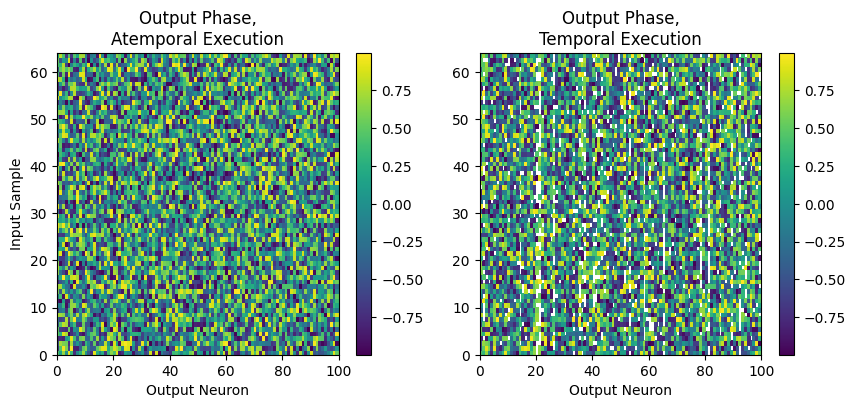

In [28]:
plt.figure(dpi=dpi, figsize=(10,4))
plt.subplot(121)
plt.pcolor(static_phases)
plt.title("Output Phase,\nAtemporal Execution")
plt.xlabel("Output Neuron")
plt.ylabel("Input Sample")
plt.colorbar()

plt.subplot(122)
plt.pcolor(dynamic_phases[:,1,:])
plt.title("Output Phase,\nTemporal Execution")
plt.xlabel("Output Neuron")
plt.colorbar()

Text(0.5, 1.0, 'Input Spikes (Drive)')

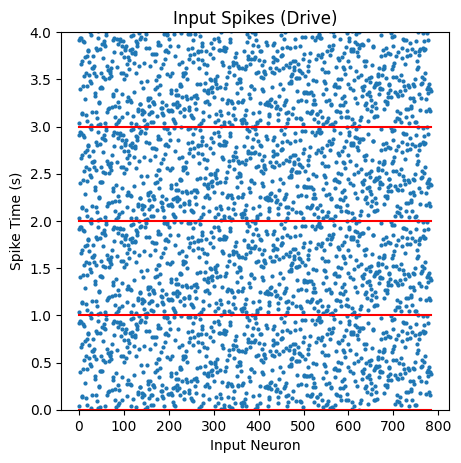

In [29]:
plt.figure(dpi=dpi, figsize=(5,5))
for i in range(10):
    plt.plot([0,784],[0.0+i,0+i], color="red")
plt.scatter(dynamic_input[0][0], dynamic_input[0][1], label="Input Spikes (Drive)", s=4)
#plt.scatter(dynamic_spikes[0][0], dynamic_spikes[0][1], label="Output Spikes (Response)")
#plt.xticks(lblinds, np.around(phases.ravel()[lblinds], decimals=2));

plt.xlabel("Input Neuron")
plt.ylabel("Spike Time (s)")
plt.ylim(0,4)
#plt.ylim(-0.5,10)
plt.title("Input Spikes (Drive)")

Text(0.5, 1.0, 'Output Spikes (Response)')

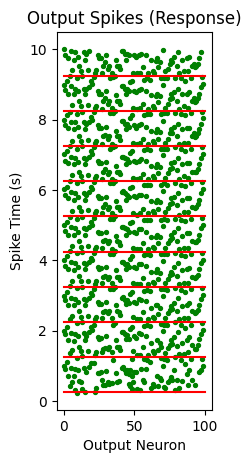

In [30]:
plt.figure(dpi=dpi, figsize=(2,5))
#plt.scatter(dynamic_input[0][0], dynamic_input[0][1], label="Input Spikes (Drive)")
for i in range(10):
    plt.plot([0,100],[0.25+i,0.25+i], color="red")
plt.scatter(dynamic_spikes[0][0], dynamic_spikes[0][1], label="Output Spikes (Response)", color="green", s=8)
#plt.xticks(lblinds, np.around(phases.ravel()[lblinds], decimals=2));
plt.xlabel("Output Neuron")
plt.ylabel("Spike Time (s)")
#plt.ylim(-0.5,10)
plt.title("Output Spikes (Response)")

In [31]:
#lambda function to take the cosine values of phases
cosxf = lambda x: np.cos(np.pi*x)

In [32]:
def plt_corr(ind):
    flat_dp = dynamic_phases[:,ind,:].ravel()
    flat_sp = static_phases.numpy().ravel()
    dp_nan = np.isnan(flat_dp)
    mask = (1.0 - 1.0*dp_nan).astype(np.bool)
    
    corr = pearsonr(flat_sp[mask], flat_dp[mask])
    
    plt.figure(dpi=dpi, figsize=(4,4))
    plt.scatter(flat_sp, flat_dp, alpha=0.05, color="blue")
    plt.xlabel("Atemporal Output Phase")
    plt.ylabel("Temporal Output Phase")
    plt.text(-.90, .75, "R="+str(np.around(corr[0], decimals=3))+"\nN="+str(len(flat_dp)))

In [78]:
def plt_cycle_corr():
    n_cycles = dynamic_phases.shape[1]
    flat_sp = static_phases.numpy().ravel()
    cvs = [] 
    
    for i in range(n_cycles):
        flat_dp = dynamic_phases[:,i,:].ravel()
        dp_nan = np.isnan(flat_dp)
        mask = (1.0 - 1.0*dp_nan).astype(np.bool)

        corr = pearsonr(flat_sp[mask], flat_dp[mask])[0]
        cvs.append(corr)
        
    cvs = np.array(cvs)
    
    plt.figure(dpi=dpi, figsize=(4,4))
    plt.plot(cvs)
    plt.xlabel("Cycle")
    plt.ylabel("Correlation\nAtemporal vs. Temporal Values")
    plt.xticks(np.arange(0,10), np.arange(1,11))

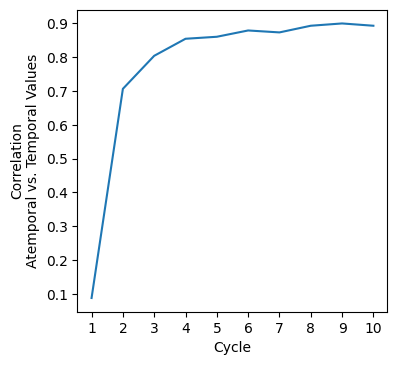

In [79]:
plt_cycle_corr()

In [80]:
def plt_corr_all():
    n = dynamic_phases.shape[1]
    
    static = []
    dynamic = []
    for ind in range(n):
        flat_dp = dynamic_phases[:,ind,:].ravel()
        flat_sp = static_phases.numpy().ravel()
        dp_nan = np.isnan(flat_dp)
        mask = (1.0 - 1.0*dp_nan).astype(np.bool)
        static.append(flat_sp[mask])
        dynamic.append(flat_dp[mask])
    
    static = np.concatenate(static, axis=0)
    dynamic = np.concatenate(dynamic, axis=0)
    corr = pearsonr(static, dynamic)

    plt.figure(dpi=dpi, figsize=(4,4))
    plt.scatter(static, dynamic, alpha=0.01, color="blue")
    #plt.scatter(np.cos(np.pi*flat_sp), np.cos(np.pi*flat_dp), alpha=0.05, color="red")
    plt.xlabel("Atemporal Output Phase")
    plt.ylabel("Temporal Output Phase")
    plt.text(-.90, .50, "R="+str(np.around(corr[0], decimals=3))+"\nN="+str(len(static)))
    
    return static, dynamic

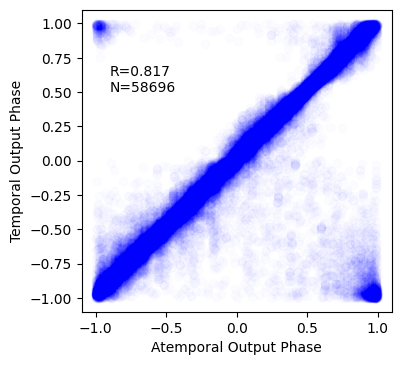

In [45]:
stat, dyn = plt_corr_all()

Text(0.5, 1.0, 'Cycle 2')

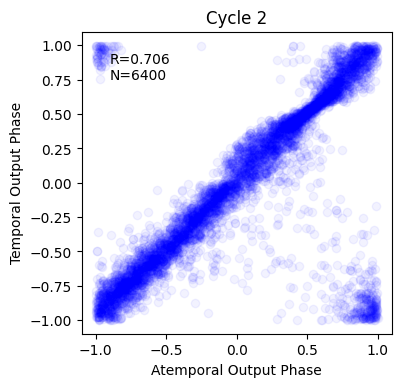

In [56]:
plt_corr(1)
plt.title("Cycle 2")

Text(0.5, 1.0, 'Cycle 10')

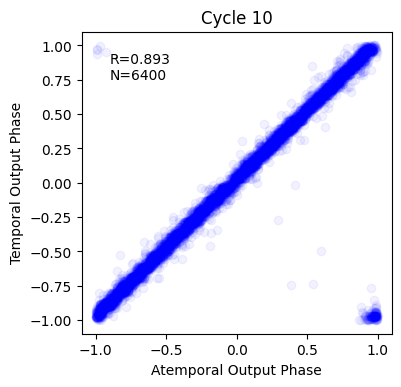

In [49]:
plt_corr(9)
plt.title("Cycle 10")

Text(0.5, 1.0, 'Cycle 2')

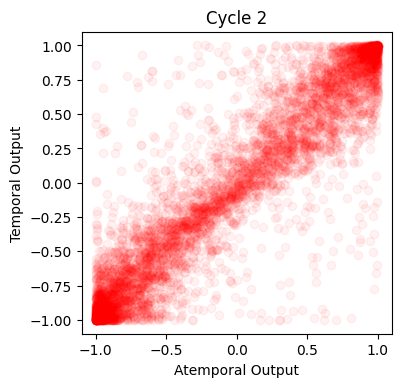

In [57]:
#plt.scatter(flat_sp, flat_dp, alpha=0.05, color="blue")
plt.figure(dpi=dpi, figsize=(4,4))
plt.scatter(cosxf(static_phases), cosxf(dynamic_phases[:,1,:]), alpha=0.05, color="red")
plt.xlabel("Atemporal Output")
plt.ylabel("Temporal Output")
plt.title("Cycle 2")

Text(0.5, 1.0, 'Cycle 10')

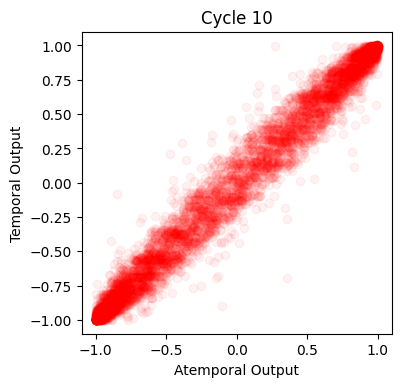

In [55]:
#plt.scatter(flat_sp, flat_dp, alpha=0.05, color="blue")
plt.figure(dpi=dpi, figsize=(4,4))
plt.scatter(cosxf(static_phases), cosxf(dynamic_phases[:,9,:]), alpha=0.05, color="red")
plt.xlabel("Atemporal Output")
plt.ylabel("Temporal Output")
plt.title("Cycle 10")

Text(-0.3, 10, '\nN=58696')

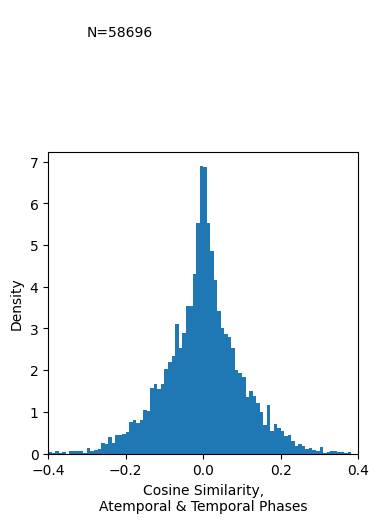

In [60]:
plt.figure(dpi=dpi, figsize=(4,4))
cos_sim = plt.hist(np.ravel(cosxf(static_phases) - cosxf(dynamic_phases[:,9,:])), bins=200, density=True);
plt.xlim(-0.4,0.4)
plt.xlabel("Cosine Similarity,\nAtemporal & Temporal Phases")
plt.ylabel("Density")
plt.text(-0.3, 10, "\nN="+str(len(stat)))

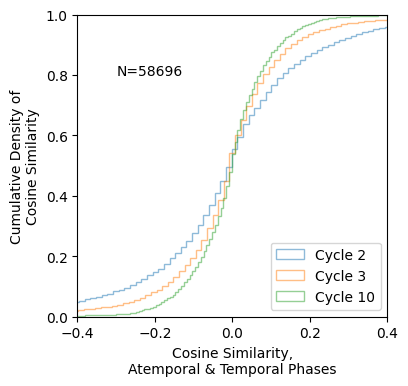

In [81]:
plt.figure(dpi=dpi, figsize=(4,4))
cos_sim2 = plt.hist(np.ravel(cosxf(static_phases) - cosxf(dynamic_phases[:,1,:])), histtype="step", label="Cycle 2", bins=250, density=True, cumulative=True, alpha=0.5);
cos_sim3 = plt.hist(np.ravel(cosxf(static_phases) - cosxf(dynamic_phases[:,2,:])), histtype="step", label="Cycle 3", bins=250, density=True, cumulative=True, alpha=0.5);
cos_sim10 = plt.hist(np.ravel(cosxf(static_phases) - cosxf(dynamic_phases[:,9,:])), histtype="step", label="Cycle 10", bins=250, density=True, cumulative=True, alpha=0.5);
plt.xlim(-0.4,0.4)
plt.xlabel("Cosine Similarity,\nAtemporal & Temporal Phases")
plt.ylabel("Cumulative Density of\nCosine Similarity")
plt.ylim(0,1)
plt.text(-0.3, 0.8, "\nN="+str(len(stat)))
plt.legend(loc="lower right")

In [80]:
def phase_portrait(layer, sol_ind, pltind, dpi=100, figsize=(2,2)):
    threshold = layer.threshold
    sol = layer.solutions[sol_ind]
    out_spikes = layer.spike_trains[sol_ind]
    
    n0_inds = np.where(out_spikes[0] == pltind)
    n0_tms = out_spikes[1][n0_inds]
    v_tms = np.concatenate([np.where(t == sol.t) for t in n0_tms])
    n0_spkz = sol.y[pltind, v_tms]
    
    plt.figure(dpi=100, figsize=(2,2))
    plt.plot(np.real(sol.y)[pltind,:], np.imag(sol.y)[pltind,:], label="Complex Potential (Z)")
    plt.scatter(np.real(n0_spkz), np.imag(n0_spkz), color="red", marker="x", label="Output Spikes")
    plt.xlabel("U")
    plt.ylabel("V")

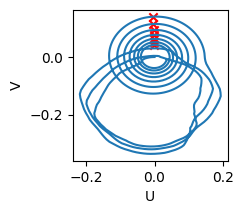

In [81]:
phase_portrait(c_layer, 0, 0)

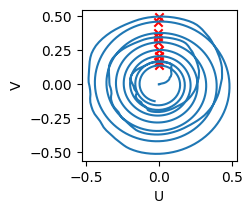

In [82]:
phase_portrait(c_layer, 0, 66)

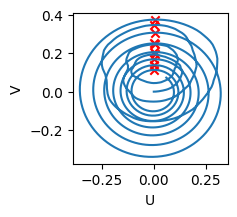

In [83]:
phase_portrait(c_layer, 0, 44)

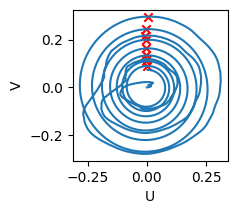

In [84]:
phase_portrait(c_layer, 0, 99)